# Soil Fertility Classification and Analysis Using Data Mining Techniques

**Algorithms Used:**
- Classification: Decision Tree
- Clustering: K-Means
- Outlier Detection: Preprocessing (Linear Regression/Discretization)

In [8]:
import numpy as np
import pandas as pd
import copy as cp
import statistics
import re
import math
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from datetime import datetime
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## Preprocessing

In [9]:
dataset1 = np.genfromtxt(r'../datasets/Dataset1.csv', delimiter=',', dtype=float, skip_header=1)
header = np.genfromtxt(r'../datasets/Dataset1.csv', delimiter=',', dtype=str, max_rows=1)
name_attribut={i:f"{n}" for i,n in enumerate(header)}
print(name_attribut)
pd.DataFrame(dataset1, columns=header)
dataset2 = np.genfromtxt(r'../datasets/Dataset2.csv', delimiter=',', dtype=float, skip_header=1)
header2 = np.genfromtxt(r'../datasets/Dataset2.csv', delimiter=',', dtype=str, max_rows=1)
name_attribut2 = {i:f"{n}" for i,n in enumerate(header2)}
print("\nDataset 2 (Result) attributes:", name_attribut2)
print(pd.DataFrame(dataset2, columns=header2))

{0: 'N', 1: 'P', 2: 'K', 3: 'pH', 4: 'EC', 5: 'OC', 6: 'S', 7: 'Zn', 8: 'Fe', 9: 'Cu', 10: 'Mn', 11: 'B', 12: 'OM', 13: 'Fertility'}

Dataset 2 (Result) attributes: {0: 'N', 1: 'P', 2: 'K', 3: 'pH', 4: 'EC', 5: 'OC', 6: 'S', 7: 'Zn', 8: 'Fe', 9: 'Cu', 10: 'Mn', 11: 'B', 12: 'OM', 13: 'Fertility'}
          N    P      K        pH        EC        OC          S        Zn  \
0     138.0  8.6  560.0  7.460000  0.620000  0.700000   5.900000  0.240000   
1     213.0  7.5  338.0  7.620000  0.750000  1.060000  25.400000  0.300000   
2     163.0  9.6  718.0  7.590000  0.510000  1.110000  14.300000  0.300000   
3     157.0  6.8  475.0  7.640000  0.580000  0.940000  26.000000  0.340000   
4     270.0  9.9  444.0  7.630000  0.400000  0.860000  11.800000  0.250000   
...     ...  ...    ...       ...       ...       ...        ...       ...   
1280  351.0  8.1  573.0  7.529318  0.538535  0.603900   3.564905  0.749935   
1281  352.0  8.1  573.0  7.529339  0.538528  0.603883   3.560155  0.750271   


In [10]:
def calculate_median(attribute, dataset):
    dataset_clean = np.delete(dataset[:, attribute], missing_values(attribute, dataset))
    sorted_list = cp.deepcopy(dataset_clean)
    sorted_list.sort()
    if sorted_list.size % 2 != 0:
        median = sorted_list[((sorted_list.size + 1) // 2) - 1]
    else:
        median = (sorted_list[(sorted_list.size // 2) - 1] + sorted_list[sorted_list.size // 2]) / 2
    return median

def missing_values(attribute, dataset):
    missing_list = []
    for i in range(0, len(dataset[:, attribute])):
        if not re.fullmatch(r"\d+\.(:?\d+)?", str(dataset[i, attribute])):
            missing_list.append(i)
    return missing_list

def central_tendency_homemade(attribute, dataset):
    dataset_clean = np.delete(dataset[:, attribute], missing_values(attribute, dataset))
    mean = dataset_clean.sum() / dataset_clean.shape[0]
    median = calculate_median(attribute, dataset)
    unique_values, counts = np.unique(dataset_clean, return_counts=True)
    max_index = np.where(counts == max(counts))[0]
    mode = [unique_values[i] for i in max_index]
    return [mean, median, mode]

def quartiles_homemade(attribute, dataset):
    dataset_clean = np.delete(dataset[:, attribute], missing_values(attribute, dataset))
    sorted_list = cp.deepcopy(dataset_clean)
    sorted_list.sort()
    q0 = sorted_list[0]
    q1 = (sorted_list[sorted_list.size // 4 - 1] + sorted_list[sorted_list.size // 4]) / 2
    q3 = (sorted_list[sorted_list.size * 3 // 4 - 1] + sorted_list[sorted_list.size * 3 // 4]) / 2
    q2 = calculate_median(attribute, dataset)
    q4 = sorted_list[-1]
    return [q0, q1, q2, q3, q4]

def std_dev_homemade(attribute, dataset):
    dataset_clean = np.delete(dataset[:, attribute], missing_values(attribute, dataset))
    mean = np.mean(dataset_clean)
    deviations = [(val - mean) ** 2 for val in dataset_clean]
    variance = np.mean(deviations)
    return np.sqrt(variance)

In [11]:
def discretization(attribute, dataset):
    vals = dataset[:, attribute].copy()
    vals.sort()
    q = 1 + (10 / 3) * np.log10(dataset.shape[0])
    num_elements = math.ceil(dataset[:, attribute].shape[0] / q)
    
    for val in range(0, dataset[:, attribute].shape[0]):
        for i in range(0, vals.shape[0], num_elements):
            if(vals[i] > dataset[val, attribute]):
                upper_bound = i
                break
        dataset[val, attribute] = np.median(vals[upper_bound - num_elements:upper_bound])
    
    return dataset

In [12]:
def replace_missing_values(method, attribute, dataset):
    missing = missing_values(attribute, dataset)
    for i in missing:
        if method == 0:
            dataset[i, attribute] = statistics.mode(dataset[:, attribute])
        else:
            dataset[i, attribute] = np.mean([dataset[j, attribute] for j in range(0, len(dataset)) 
                                              if dataset[j, -1] == dataset[i, -1] and not j in missing])
    return dataset

def replace_outliers(method, attribute, dataset):
    outliers = []
    if method == 0:  # Linear Regression
        IQR = (quartiles_homemade(attribute, dataset)[-2] - quartiles_homemade(attribute, dataset)[1]) * 1.5
        for i in range(0, len(dataset[:, attribute])):
            if (dataset[i, attribute] > (quartiles_homemade(attribute, dataset)[-2] + IQR) or 
                dataset[i, attribute] < (quartiles_homemade(attribute, dataset)[1] - IQR)):
                outliers.append(i)
        
        X = np.delete(dataset, attribute, axis=1)
        X = np.delete(X, outliers, axis=0)
        y = dataset[:, attribute]
        y = np.delete(y, outliers, axis=0).reshape(-1, 1)

        model = LinearRegression().fit(X, y)
        
        for i in outliers:
            x2 = np.delete(dataset, attribute, axis=1)
            X_new = x2[i, :].T.reshape(1, -1)
            dataset[i, attribute] = model.predict(X_new)[0][0]
    else:  # Discretization
        dataset = discretization(attribute, dataset)
    
    return dataset

def replace_missing_general(method, dataset):
    for i in range(0, dataset.shape[1] - 1):
        dataset = replace_missing_values(method, i, dataset)
    return dataset

def replace_outliers_general(method, dataset):
    for i in range(0, dataset.shape[1] - 1):
        dataset = replace_outliers(method, i, dataset)
    return dataset

In [13]:
def remove_duplicates(dataset):
    print(f"Before: {len(dataset)} rows")
    dataset = np.unique(dataset, axis=0, return_index=False)
    print(f"After: {len(dataset)} rows")
    return dataset

def correlation_coef(attribute1, attribute2, dataset):
    mean1 = np.mean(dataset[:, attribute1])
    mean2 = np.mean(dataset[:, attribute2])
    std1 = std_dev_homemade(attribute1, dataset)
    std2 = std_dev_homemade(attribute2, dataset)
    return (dataset[:, attribute1].dot(dataset[:, attribute2]) - (len(dataset) * mean1 * mean2)) / ((len(dataset) - 1) * (std1 * std2))

def reduce_dimensions(threshold, dataset):
    to_delete = []
    for i in range(0, dataset.shape[1] - 1):
        for j in range(i + 1, dataset.shape[1]):
            if (np.abs(correlation_coef(i, j, dataset)) > threshold):
                print(i, j)
                to_delete.append(i)
    dataset = np.delete(dataset, to_delete, axis=1)
    return dataset

In [14]:
def normalize(method, attribute, dataset):
    if method:  # Min-Max normalization
        vmin = 0
        vmax = 1
        vmin_old = dataset[:, attribute].min()
        vmax_old = dataset[:, attribute].max()
        for val in range(0, dataset[:, attribute].shape[0]):
            dataset[val, attribute] = vmin + (vmax - vmin) * ((dataset[val, attribute] - vmin_old) / (vmax_old - vmin_old))
    else:  # Z-score normalization
        vmean = np.mean(dataset[:, attribute])
        s = np.mean((dataset[:, attribute] - vmean) ** 2)
        for val in range(0, dataset[:, attribute].shape[0]):
            dataset[val, attribute] = (dataset[val, attribute] - vmean) / s
    return dataset

def normalize_general(method, dataset):
    for i in range(0, dataset.shape[1] - 1):
        dataset = normalize(method, i, dataset)
    return dataset

In [15]:
# Preprocess Dataset 1 (Classification)
print("PREPROCESSING DATASET 1")
dataset1 = replace_missing_general(1, dataset1)
dataset1 = replace_outliers_general(0, dataset1)   
dataset1 = remove_duplicates(dataset1)
dataset1 = reduce_dimensions(0.75, dataset1)
dataset1 = normalize_general(1, dataset1)
print("Dataset 1 preprocessing completed!\n")

# Preprocess Dataset 2 (Clustering)
print("PREPROCESSING DATASET 2")
dataset2 = replace_missing_general(1, dataset2)
dataset2 = replace_outliers_general(0, dataset2)   
dataset2 = remove_duplicates(dataset2)
dataset2 = reduce_dimensions(0.75, dataset2)
dataset2 = normalize_general(1, dataset2)
print("Dataset 2 preprocessing completed!\n")

PREPROCESSING DATASET 1
Before: 885 rows
After: 882 rows
5 12
Dataset 1 preprocessing completed!

PREPROCESSING DATASET 2
Before: 1285 rows
After: 1282 rows
0 13
1 3
5 12
Dataset 2 preprocessing completed!



## Distance Metrics

In [16]:
def distance(instance1, instance2, method):
    if method == 0:  # Cosine
        return 1 - ((np.sum([instance1[i] * instance2[i] for i in range(0, len(instance1))])) / 
                    (math.sqrt(np.sum([i**2 for i in instance1])) * math.sqrt(np.sum([i**2 for i in instance2]))))
    else:  # Minkowski
        return sum(np.abs(instance1 - instance2)**method)**(1 / method)

## Evaluation Metrics

In [17]:
def confusion_matrix_custom(y_test, y_pred):
    N = len(np.unique(y_test))
    M = np.zeros((N, N), dtype=int)
    for i in range(0, y_test.shape[0]):
        M[int(y_test[i])][int(y_pred[i])] += 1
    return M

def values(m):
    TP = m.diagonal()
    FP = m.sum(axis=0) - TP
    FN = m.sum(axis=1) - TP
    TN = m.sum() - (TP + FN + FP)
    return TP, FN, FP, TN

def recall_score_custom(TP, FN):
    return TP / (TP + FN)

def precision_score_custom(TP, FP):
    return TP / (TP + FP)

def false_positive_rate(FP, TN):
    return FP / (FP + TN)

def specificity_score_custom(TN, FP):
    return TN / (TN + FP)

def accuracy_score_custom(M):
    return np.sum(M.diagonal()) / np.sum(M)

def f1_score_custom(TP, FP, FN):
    recall = recall_score_custom(TP, FN)
    precision = precision_score_custom(TP, FP)

    if np.any(np.isnan(recall)) or np.any(np.isnan(precision)) or np.all(recall + precision == 0):
        f1 = 0.0
    else:
        f1 = 2 * (recall * precision) / (recall + precision)

    return f1

In [18]:
def classification_metrics(y_test, y_pred):
    M = confusion_matrix_custom(y_test, y_pred)
    TP, FN, FP, TN = values(M)
    
    print(f"Global Accuracy: {np.mean(accuracy_score_custom(M)):.4f}")
    print(f"Global Recall: {np.mean(recall_score_custom(TP, FN)):.4f}")
    print(f"Global Precision: {np.mean(precision_score_custom(TP, FP)):.4f}")
    print(f"Global Specificity: {np.mean(specificity_score_custom(TN, FP)):.4f}")
    print(f"Global F1 Score: {np.mean(f1_score_custom(TP, FP, FN)):.4f}")

    print(f"\nPer-class Recall: {recall_score_custom(TP, FN)}")
    print(f"Per-class Precision: {precision_score_custom(TP, FP)}")
    print(f"Per-class False Positive Rate: {false_positive_rate(FP, TN)}")
    print(f"Per-class Specificity: {specificity_score_custom(TN, FP)}")
    print(f"Per-class F1 Score: {f1_score_custom(TP, FP, FN)}")
    
    sns.heatmap(M, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

## 1. Supervised Learning

In [19]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        random.seed(random_state)

    data = list(zip(X, y))
    random.shuffle(data)

    split_index = int(len(data) * (1 - test_size))

    train_data = data[:split_index]
    test_data = data[split_index:]

    X_train, y_train = zip(*train_data)
    X_test, y_test = zip(*test_data)

    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, Y_train, Y_test = train_test_split(dataset1[:, :-1], dataset1[:, -1], test_size=0.2, random_state=42)

### Decision Tree Classifier

In [20]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        #desicion node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        # leaf node
        self.value = value

In [21]:
class DtClassifier():
    def __init__(self, min_samples_split, max_depth, info_gain_method, n_features=None):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.info_gain_method = info_gain_method

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        # Pre-pruning
        if num_samples < self.min_samples_split or curr_depth == self.max_depth:
            leaf_value = self.calculate_leaf_value(Y)
            return Node(value=leaf_value)

        # find the best split
        best_split = self.get_best_split(dataset, num_samples, num_features)

        # Pre-pruning
        if best_split is None or "info_gain" not in best_split or best_split["info_gain"] <= 0:
            leaf_value = self.calculate_leaf_value(Y)
            return Node(value=leaf_value)


        left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
        right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)

        # Post-pruning
        current_info_gain = best_split["info_gain"]
        leaf_info_gain = self.information_gain(Y, None, None, self.info_gain_method)
        if leaf_info_gain >= current_info_gain:
            leaf_value = self.calculate_leaf_value(Y)
            return Node(value=leaf_value)

        return Node(
            best_split["feature_index"],
            best_split["threshold"],
            left_subtree,
            right_subtree,
            best_split["info_gain"]
        )
    
    def get_best_split(self, dataset, num_samples, num_features):
    
        best_split = {}
        max_info_gain = -float("inf")
        
        if self.n_features is not None:
            feature_indices = np.random.choice(num_features, self.n_features, replace=False)
        else:
            feature_indices = range(num_features)
        
        for feature_index in feature_indices:
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y, self.info_gain_method)

                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
      
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode):
        if l_child is None or r_child is None:
            return 0

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)

        if mode == "Gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))

        return gain

    
    def entropy(self, y):
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        unique_classes, counts = np.unique(Y, return_counts=True)
        return unique_classes[np.argmax(counts)]
    
    def fit(self, X, Y):
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value is not None:
            print(f"Reached leaf node: Predicted Value {tree.value}")
            
            return tree.value

        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            print(f"At Node: Feature {tree.feature_index} <= Threshold {tree.threshold}, Move to Left Subtree")
            
            return self.make_prediction(x, tree.left)
        else:
            print(f"At Node: Feature {tree.feature_index} > Threshold {tree.threshold}, Move to Right Subtree")
            
            return self.make_prediction(x, tree.right)
        

In [22]:
DTClassifier = DtClassifier(min_samples_split=2, max_depth=5, info_gain_method="Gini")
DTClassifier.fit(X_train, Y_train)
y_pred = DTClassifier.predict(X_test) 
prediction = DTClassifier.predict(np.array([[0.01801802, 0.36641221, 0.3627451, 0.33027523, 0.62666667, 0.74576271, 0.11841283, 0.07156673, 0.39303483, 0.1322228, 0.27280741, 0.03066867]]))

At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 1 > Threshold 0.5954198473282442, Move to Right Subtree
At Node: Feature 0 <= Threshold 0.7717717717717718, Move to Left Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 1 <= Threshold 0.5954198473282442, Move to Left Subtree
At Node: Feature 0 > Threshold 0.6426426426426426, Move to Right Subtree
At Node: Feature 8 > Threshold 0.08955223880597014, Move to Right Subtree
At Node: Feature 1 > Threshold 0.1603053435114504, Move to Right Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 <= Threshold 0.6216216216216216, Move to Left Subtree
At Node: Feature 1 <= Threshold 0.48091603053435106, Move to Left Subtree
At Node: Feature 7 > Threshold 0.02514506769825919, Move to Right Subtree
At Node: Feature 0 <= Threshold 0.5645645645645646, Move to Left Subtree
At Node: Feature 9 > Threshold 0.1170323928

Parameters used by DecisionTreeClassifier:
Criterion: gini
Splitter: best
Max Depth: 5
Min Samples Split: 2
Min Samples Leaf: 1
Precision for Class 0: 0.9375
Precision for Class 1: 0.9139784946236559
Precision for Class 2: 0.5
Accuracy:0.9152542372881356


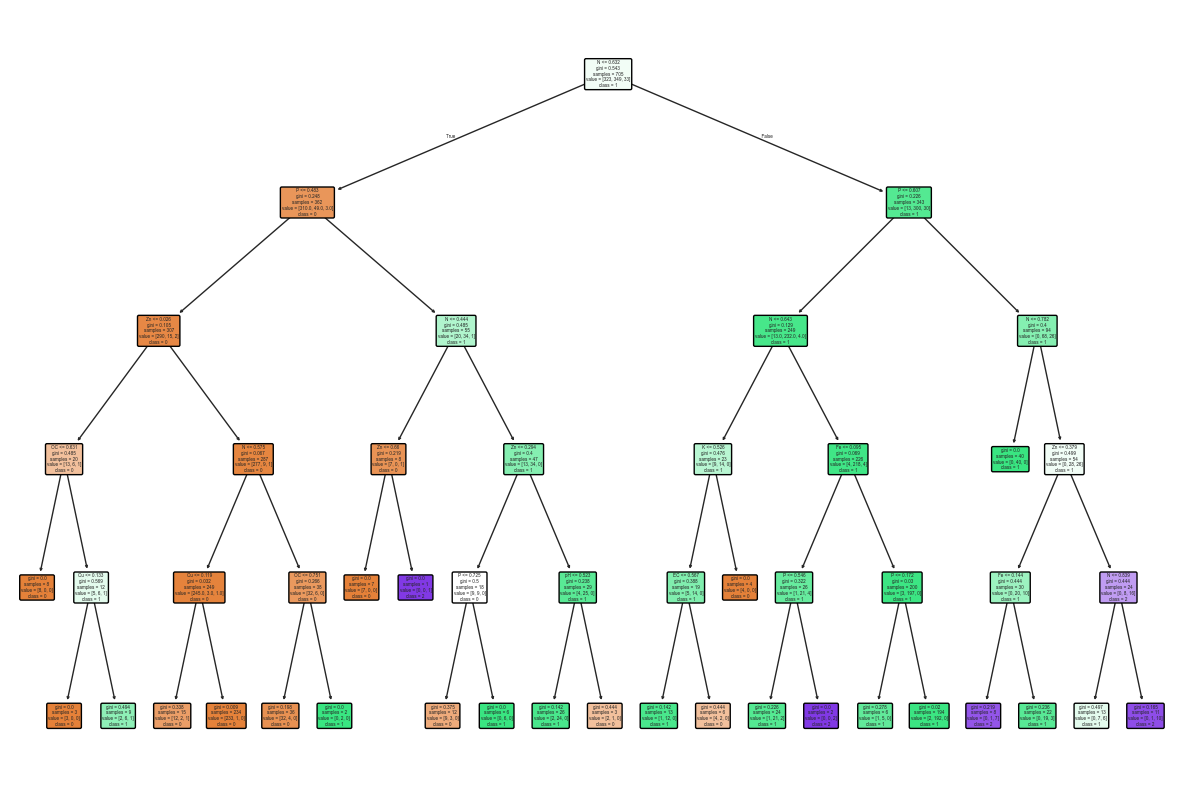

In [23]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score

DTClassifier = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
DTClassifier.fit(X_train, Y_train)
pred = DTClassifier.predict(X_test)

precision_per_class = precision_score(Y_test, pred, average=None)
accuracy = accuracy_score(Y_test, pred)
print("Parameters used by DecisionTreeClassifier:")
print(f"Criterion: {DTClassifier.criterion}")
print(f"Splitter: {DTClassifier.splitter}")
print(f"Max Depth: {DTClassifier.max_depth}")
print(f"Min Samples Split: {DTClassifier.min_samples_split}")
print(f"Min Samples Leaf: {DTClassifier.min_samples_leaf}")
for class_idx, precision in enumerate(precision_per_class):
    print(f'Precision for Class {class_idx}: {precision}')
print(f'Accuracy:{accuracy}')
    
# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(DTClassifier, feature_names=header[:-1], class_names=[str(int(c)) for c in np.unique(Y_train)], filled=True, rounded=True)
plt.show()


Global Accuracy: 0.9040
Global Recall: 0.6725
Global Precision: 0.7208
Global Specificity: 0.9406
Global F1 Score: 0.6838

Per-class Recall: [0.96153846 0.91304348 0.14285714]
Per-class Precision: [0.92592593 0.90322581 0.33333333]
Per-class False Positive Rate: [0.06060606 0.10588235 0.01176471]
Per-class Specificity: [0.93939394 0.89411765 0.98823529]
Per-class F1 Score: [0.94339623 0.90810811 0.2       ]


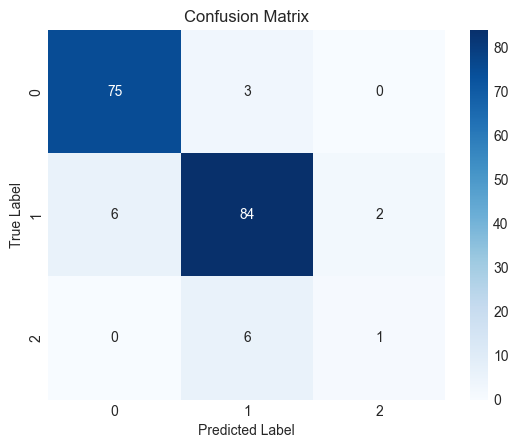

In [24]:
classification_metrics(Y_test, y_pred)

In [25]:
max_depth_values = [None, 5, 8, 10, 12]
min_samples_split_values = [2, 3, 4, 5, 6]

best_accuracy = 0
best_params = {}

print("Tuning Decision Tree hyperparameters...\n")

# Loop through hyperparameter values
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        # Create and train the model
        dt_classifier = DtClassifier(
            info_gain_method='Gini',
            max_depth=max_depth,
            min_samples_split=min_samples_split
        )
        dt_classifier.fit(X_train, Y_train)

        # Make predictions on the test set
        y_pred = dt_classifier.predict(X_test)

        # Evaluate accuracy
        accuracy = accuracy_score(Y_test, y_pred)
        print(f"max_depth={max_depth}, min_samples_split={min_samples_split}, accuracy={accuracy:.4f}")
        
        # Check if this set of hyperparameters gives better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
            }

# Print the best hyperparameters and accuracy
print(f"\nBest Hyperparameters: {best_params}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")

Tuning Decision Tree hyperparameters...

At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 1 > Threshold 0.5954198473282442, Move to Right Subtree
At Node: Feature 0 <= Threshold 0.7717717717717718, Move to Left Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 1 <= Threshold 0.5954198473282442, Move to Left Subtree
At Node: Feature 0 > Threshold 0.6426426426426426, Move to Right Subtree
At Node: Feature 8 > Threshold 0.08955223880597014, Move to Right Subtree
At Node: Feature 1 > Threshold 0.1603053435114504, Move to Right Subtree
At Node: Feature 6 > Threshold 0.11841282667247462, Move to Right Subtree
At Node: Feature 0 > Threshold 0.6606606606606606, Move to Right Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 <= Threshold 0.6216216216216216, Move to Left Subtree
At Node: Feature 1 <= Threshold 0.48091603053435106, Move to Left Subtree
At

## 2. Unsupervised Learning

In [26]:
dataset1_unsupervised = dataset2[:, :-1]

### K-Means Clustering

In [27]:
class K_MEANS:
    def __init__(self, k, distance_method, centroid_method, max_iterations):
        self.k = k
        self.centroids = []
        self.dataset_labeled = None  # Initialize as None
        self.centroid_method = centroid_method
        self.distance_method = distance_method
        self.max_iterations = max_iterations
    
    def fit(self, xt):
        self.X_train = xt
        self.dataset_labeled = np.hstack((self.X_train.copy(), -1 * np.ones((self.X_train.shape[0], 1))))
    
    def centroid_selection(self, method):
        if method == 0:  # Random without duplicates
            self.centroids.extend(self.X_train[random.sample(range(self.X_train.shape[0]), self.k), :])
        elif method == 1:  # Better picking (k-means++)
            self.centroids.append(list(self.X_train[np.random.choice(self.X_train.shape[0]), :]))
            dist = np.apply_along_axis(lambda x: distance(x, self.centroids[0], self.distance_method), axis=1, arr=self.X_train)
            ind = np.argsort(dist)
            for i in range(self.k, 0, -1):
                self.centroids.append(list(self.X_train[ind[int((len(ind) / self.k) * i) - 1], :]))
    
    def cluster(self):
        # Choose centroids
        self.centroid_selection(self.centroid_method)
        
        # Iterate until convergence
        change = True
        num_iterations = 0
        
        while(change):
            # Calculate distances and assign clusters
            for j in range(self.X_train.shape[0]):
                distances = []
                for i in range(self.k):
                    distances.append(distance(instance1=self.centroids[i], 
                                            instance2=self.X_train[j, :], 
                                            method=self.distance_method))
                # Assign to nearest centroid
                cluster = np.argmin(distances)
                self.dataset_labeled[j, -1] = cluster
            
            # Update centroids
            old_centroids = self.centroids.copy()
            for i in range(self.k):
                cluster_points = np.array([row[:-1] for row in self.dataset_labeled if row[-1] == i])
                self.centroids[i] = np.array([np.average(cluster_points[:, j]) for j in range(cluster_points.shape[1])])

            # Check for convergence
            if np.linalg.norm(np.array(self.centroids) - np.array(old_centroids)) < 0.0001 or num_iterations > self.max_iterations:
                change = False
            num_iterations += 1
        
        return self.dataset_labeled
    
    # Bonus: Predict cluster for new instance
    def predict(self, instance):
        distances = []
        for i in range(self.k):
            distances.append(distance(self.centroids[i], instance, self.distance_method))
        cluster = np.argmin(distances)
        cluster_points = np.array([row[:-1] for row in self.dataset_labeled if row[-1] == cluster])
        return cluster, cluster_points

- Silhouette


In [28]:
def silhouette_score_custom(data, labels, metric):
    num_points = len(data)
    unique_labels = np.unique(labels)
    silhouette_values = np.zeros(num_points)

    intra_cluster_distances = np.zeros(num_points)
    inter_cluster_distances = np.zeros(num_points)

    for i in range(num_points):
        # ai (intra-cluster distance)
        label_i = labels[i]
        cluster_i_indices = np.where(labels == label_i)[0]  # Get own cluster points
        
        if len(cluster_i_indices) == 1:
            silhouette_i = 0  # Set silhouette score to 0 for single point clusters
        else:
            a_i = np.mean([distance(data[i], data[j], metric) for j in cluster_i_indices if j != i])
            inter_cluster_distances[i] = a_i

            # bi (inter-cluster distance)
            b_i_values = []
            for label_j in unique_labels:
                if label_j != label_i:
                    cluster_j_indices = np.where(labels == label_j)[0]  # Get neighbor cluster points
                    b_ij = np.mean([distance(data[i], data[j], metric) for j in cluster_j_indices])
                    b_i_values.append(b_ij)
            
            # Get the average distance to the nearest neighbor cluster
            b_i = min(b_i_values) if b_i_values else 0
            intra_cluster_distances[i] = b_i

            # Silhouette score of point i
            silhouette_i = (b_i - a_i) / max(a_i, b_i)
            
        silhouette_values[i] = silhouette_i
            
    # Overall silhouette score
    silhouette_score_avg = np.mean(silhouette_values)
    
    # Calculate overall intra-cluster and inter-cluster distances
    intra_distance = np.sum(intra_cluster_distances)
    inter_distance = np.sum(inter_cluster_distances)

    return silhouette_score_avg, intra_distance, inter_distance


### Experiments

In [30]:
# Train custom K-Means
kmeans_custom = K_MEANS(k=3, distance_method=1, centroid_method=1, max_iterations=10000)
kmeans_custom.fit(dataset1_unsupervised)
result = kmeans_custom.cluster()

print("K-Means clustering completed!")

# Test prediction for new instance
print(f"\n{'='*60}")
print("TESTING K-MEANS PREDICTION")
print(f"{'='*60}")

# Show dataset info
print(f"Dataset shape: {dataset1_unsupervised.shape}")
print(f"Features ({dataset1_unsupervised.shape[1]}): {list(header[:-1])}")

# Test with first training sample
test_sample = dataset1_unsupervised[0]
print(f"\nTest Sample: {test_sample}")

prediction = kmeans_custom.predict(test_sample)
print(f"\n✅ Predicted Cluster: {prediction[0]}")
print(f"✅ Cluster Size: {len(prediction[1])} similar soil samples")
print(f"{'='*60}\n")
print(f"Predicted cluster: {prediction[0]}")
print(f"Cluster size: {len(prediction[1])} points")

# Evaluate custom K-Means
score_custom, intra_dist_custom, inter_dist_custom = silhouette_score_custom(dataset1_unsupervised, result[:, -1], 0)
print(f"\nCustom K-Means Silhouette Score: {score_custom}")

# Compare with sklearn K-Means
kmeans_sklearn = KMeans(n_clusters=3, max_iter=10000, init='random', tol=0.001)
kmeans_sklearn.fit(dataset1_unsupervised)

silhouette_sklearn = silhouette_score(dataset1_unsupervised, kmeans_sklearn.labels_, metric='cosine')
print(f"\nsklearn K-Means Silhouette Score: {silhouette_sklearn:}")


K-Means clustering completed!

TESTING K-MEANS PREDICTION
Dataset shape: (1282, 10)
Features (10): [np.str_('N'), np.str_('P'), np.str_('K'), np.str_('pH'), np.str_('EC'), np.str_('OC'), np.str_('S'), np.str_('Zn'), np.str_('Fe'), np.str_('Cu'), np.str_('Mn'), np.str_('B'), np.str_('OM')]

Test Sample: [3.90946502e-01 9.81589422e-01 7.44186047e-01 4.30176565e-01
 5.04389038e-02 3.11411992e-01 1.69117647e-01 4.34129693e-01
 2.43409364e-01 9.68028832e-04]

✅ Predicted Cluster: 2
✅ Cluster Size: 553 similar soil samples

Predicted cluster: 2
Cluster size: 553 points

Custom K-Means Silhouette Score: 0.34833476378047773

sklearn K-Means Silhouette Score: 0.33541831088936347
